In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score

In [3]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


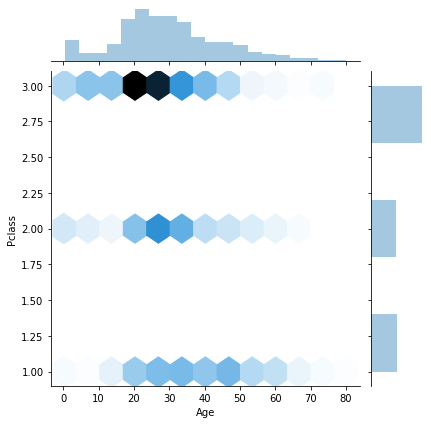

In [4]:
sns.jointplot(x='Age', y='Pclass', data=df, kind='hex')

In [5]:
df['Sex']= df['Sex'].map({'male': 0, 'female': 1})
df['Embarked']=df['Embarked'].map({'S':0,'Q':1,'C':2, np.NaN : 0})
df['GroupSize']=df['SibSp']+df['Parch']+1

df['Alone']= df['GroupSize'].map(lambda x: 1 if x == 1 else 0)

l=df.groupby('Pclass').mean()['Age']
def avg_age(p_row):
    pclass = p_row[0]
    age = p_row[1]
    if np.isnan(age):
        return round(l[pclass])
    else:
        return round(age)
df['Age']= df[['Pclass','Age']].apply(avg_age, axis=1)


def age_r(p):
    if p in range(0,15):
        return 0
    elif p in range(15,30):
        return 1
    elif p in range(30,45):
        return 2
    elif p in range(45,60):
        return 3
    elif p in range(60,75):
        return 4
    else:
        return 5
    
def fare_r(p):
    if round(p) in range(0,25):
        return 0
    elif round(p) in range(25,50):
        return 1
    elif round(p) in range(50,100):
        return 2
    elif round(p) in range(100, 200):
        return 3
    elif round(p) in range(200,300):
        return 4
    elif round(p) in range(300,400):
        return 5
    else:
        return 6
    

    
df['Title']= df['Name'].apply( lambda x: (x.split(',')[1]).split()[0] )
def title(p):
    if p == 'Mr.':
        return 0
    elif (p == 'Mrs.') | (p == 'Mme.') :
        return 1
    elif (p == 'Miss.') | (p == 'Ms.') | (p == 'Mlle.'):
        return 2
    elif p == 'Master.':
        return 3
    else:
        return 4

df['Title']=df['Title'].apply(lambda x: title(x))    
df['Age Range']=df['Age'].apply(lambda x: age_r(x))
df['Fare Range']=df['Fare'].apply(lambda x: fare_r(x))

df['Cabin']= (df['Cabin'].isnull()).map({ True: 0, False: 1, np.NaN: 1})

df.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Age', 'Fare', 'GroupSize'], axis=1, inplace= True)

df.head()

,Survived,Pclass,Sex,Cabin,Embarked,Alone,Title,Age Range,Fare Range
0,0,3,0,0,0,0,0,1,0
1,1,1,1,1,2,0,1,2,2
2,1,3,1,0,0,1,2,1,0
3,1,1,1,1,0,0,1,2,2
4,0,3,0,0,0,1,0,2,0


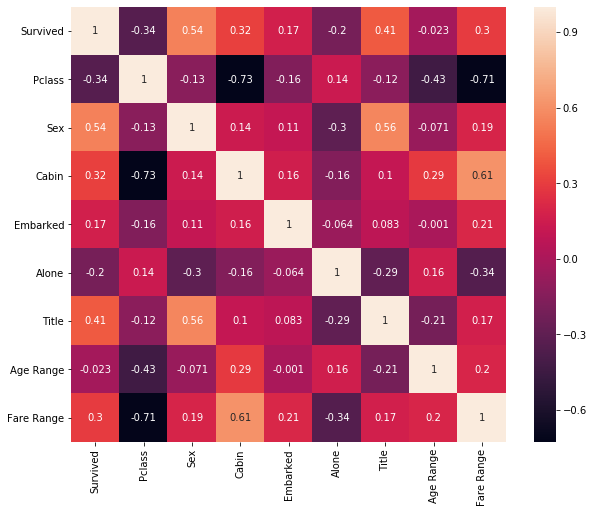

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, square=True )

In [7]:
X=df.drop('Survived', axis=1)
y=df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

rfc = RandomForestClassifier(n_estimators=7000)

#rfc.set_params(criterion = 'entropy', n_estimators=80, max_depth = 3, min_samples_split=30)

rfc.fit(X_train, y_train)
print(rfc.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 7000, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [8]:
pred= rfc.predict(X_test)
print( classification_report(y_test, pred) )
print( accuracy_score(y_test, pred) )

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       216
           1       0.80      0.76      0.78       141

    accuracy                           0.83       357
   macro avg       0.82      0.82      0.82       357
weighted avg       0.83      0.83      0.83       357

0.8291316526610645


Variable: Title                Importance: 0.26
Variable: Sex                  Importance: 0.22
Variable: Pclass               Importance: 0.13
Variable: Age Range            Importance: 0.12
Variable: Fare Range           Importance: 0.11
Variable: Embarked             Importance: 0.07
Variable: Cabin                Importance: 0.06
Variable: Alone                Importance: 0.04


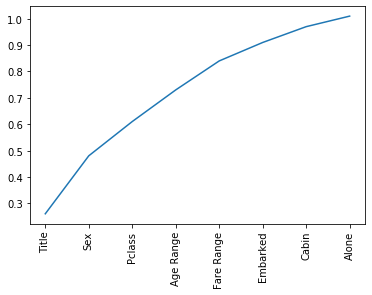

In [9]:
features = df
feature_list = list((features.drop('Survived', axis=1)).columns)

# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

x_values = list(range(len(importances)))
plt.xticks(x_values, sorted_features, rotation = 'vertical')

sns.lineplot(x=x_values, y=cumulative_importances)

In [10]:
#rfc.set_params(criterion='gini', min_samples_leaf=2, min_samples_split= 12, n_estimators= 1000)
#last saved params

#pickle.dump(rfc, open('rfc_model.sav', 'wb'))

In [11]:
#rfc = pickle.load(open('rfc_model.sav', 'rb'))

In [12]:

df_test = pd.read_csv('test.csv')
p_id_test=df_test['PassengerId']
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [13]:
df_test['Fare'].fillna(12.985, inplace=True)
df_test['Sex']= df_test['Sex'].map({'male': 0, 'female': 1})
df_test['Embarked']=df_test['Embarked'].map({'S':0,'Q':1,'C':2, np.NaN : 0})
df_test['GroupSize']=df_test['SibSp']+df_test['Parch']+1

df_test['Alone']= df_test['GroupSize'].map(lambda x: 1 if x == 1 else 0)

l=df_test.groupby('Pclass').mean()['Age']
def avg_age(p_row):
    pclass = p_row[0]
    age = p_row[1]
    if np.isnan(age):
        return round(l[pclass])
    else:
        return round(age)
df_test['Age']= df_test[['Pclass','Age']].apply(avg_age, axis=1)


def age_r(p):
    if p in range(0,15):
        return 0
    elif p in range(15,30):
        return 1
    elif p in range(30,45):
        return 2
    elif p in range(45,60):
        return 3
    elif p in range(60,75):
        return 4
    else:
        return 5
    
def fare_r(p):
    if round(p) in range(0,25):
        return 0
    elif round(p) in range(25,50):
        return 1
    elif round(p) in range(50,100):
        return 2
    elif round(p) in range(100, 200):
        return 3
    elif round(p) in range(200,300):
        return 4
    elif round(p) in range(300,400):
        return 5
    else:
        return 6
    

    
df_test['Title']= df_test['Name'].apply( lambda x: (x.split(',')[1]).split()[0] )
def title(p):
    if p == 'Mr.':
        return 0
    elif (p == 'Mrs.') | (p == 'Mme.') :
        return 1
    elif (p == 'Miss.') | (p == 'Ms.') | (p == 'Mlle.'):
        return 2
    elif p == 'Master.':
        return 3
    else:
        return 4

df_test['Title']=df_test['Title'].apply(lambda x: title(x))    
df_test['Age Range']=df_test['Age'].apply(lambda x: age_r(x))
df_test['Fare Range']=df_test['Fare'].apply(lambda x: fare_r(x))

df_test['Cabin']= (df_test['Cabin'].isnull()).map({ True: 0, False: 1, np.NaN: 1})

df_test.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Age', 'Fare', 'GroupSize'], axis=1, inplace= True)

df_test.head()

,Pclass,Sex,Cabin,Embarked,Alone,Title,Age Range,Fare Range
0,3,0,0,1,1,0,2,0
1,3,1,0,0,0,1,3,0
2,2,0,0,1,1,0,4,0
3,3,0,0,0,1,0,1,0
4,3,1,0,0,0,1,1,0


In [14]:
pred= pd.Series(rfc.predict(df_test))
sub = (pd.concat([p_id_test, pred], axis=1)).rename(columns={0: 'Survived'})
#sub.to_csv('Submission.csv', index=False)

In [15]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [2,4, 8, 10], "min_samples_split" : [2, 4, 10, 12], "n_estimators": [400, 700, 1000]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=3)

In [16]:
gs = gs.fit(X_train, y_train)

print(gs.best_score_) 
print(gs.best_params_)

0.8389513108614233
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 1000}


In [17]:
rf.set_params(criterion='gini', min_samples_leaf=2, min_samples_split= 12, n_estimators= 1000)
rf.fit(X_train, y_train)
predict= rf.predict(X_test)
print( classification_report(y_test, predict) )
print( accuracy_score(y_test, predict) )

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       216
           1       0.84      0.67      0.75       141

    accuracy                           0.82       357
   macro avg       0.83      0.80      0.80       357
weighted avg       0.82      0.82      0.82       357

0.8207282913165266


In [18]:
import xgboost as xgb

In [84]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

c:\python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [88]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.2,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}  # the number of classes that exist in this datset
num_round = 25  # the number of training iterations

# training and testing - numpy matrices
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)


best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Numpy array precision:", precision_score(y_test, best_preds))

Numpy array precision: 0.8482142857142857


In [89]:
test = xgb.DMatrix(df_test)
preds = bst.predict(test)
best_preds = pd.Series([np.argmax(line) for line in preds])

sub = (pd.concat([p_id_test, best_preds], axis=1)).rename(columns={0: 'Survived'})
#sub.to_csv('Submission.csv', index=False)